In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
import os
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD

import functions_data_processing as fdp


%matplotlib inline

In [2]:
#Reading the csv file as a pandas data frame

df_original = pd.read_csv('HomeC.csv')
#df.head(5)
print(df_original.shape)

(503911, 32)


/tmp/ipykernel_56673/464487055.py:3: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv('HomeC.csv')


In [3]:
# Configuration: threshold, intervals, Microwave etc.

In [4]:
#Printing the types of each attribute in the data frame

print(df_original.dtypes)
#df_original.info()

time                    object
use [kW]               float64
gen [kW]               float64
House overall [kW]     float64
Dishwasher [kW]        float64
Furnace 1 [kW]         float64
Furnace 2 [kW]         float64
Home office [kW]       float64
Fridge [kW]            float64
Wine cellar [kW]       float64
Garage door [kW]       float64
Kitchen 12 [kW]        float64
Kitchen 14 [kW]        float64
Kitchen 38 [kW]        float64
Barn [kW]              float64
Well [kW]              float64
Microwave [kW]         float64
Living room [kW]       float64
Solar [kW]             float64
temperature            float64
icon                    object
humidity               float64
visibility             float64
summary                 object
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover              object
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProbability      float64
dtype: o

In [5]:
#Setting the time attribute as index of the data frame

df_original['time'].head()
print(' start ' , time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df_original['time'].iloc[0]))))
time_index = pd.date_range('2016-01-01 05:00', periods=len(df_original),  freq='min') # An asumption is made that the starting date is 2016-01-01 05:00
time_index = pd.DatetimeIndex(time_index)
df_original = df_original.set_index(time_index)
df_original = df_original.drop(['time'], axis=1)
df_original.iloc[np.r_[0:5,-5:0]].iloc[:,0]
df_original.tail(5)




 start  2016-01-01 06:00:00


,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
2016-12-16 03:26:00,1.599333,0.003233,1.599333,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
2016-12-16 03:27:00,1.924267,0.003217,1.924267,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
2016-12-16 03:28:00,1.978200,0.003217,1.978200,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
2016-12-16 03:29:00,1.990950,0.003233,1.990950,0.000050,0.494700,0.634133,0.042100,0.004917,0.008133,0.012833,...,8.74,Light Rain,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51
2016-12-16 03:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print(df_original.index[-2])

2016-12-16 03:29:00


0.01098299342767161
0.004
1.9298 0.0


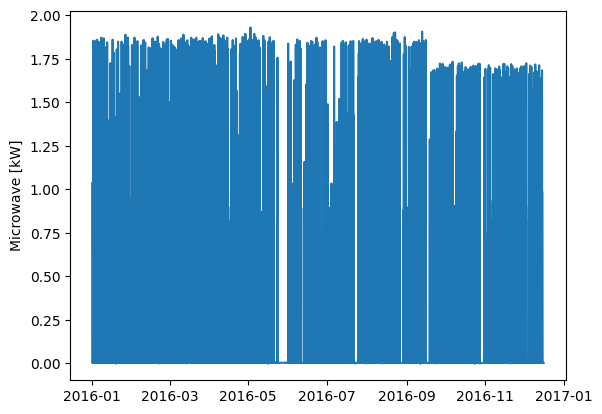

In [7]:
#Graphing the functioning of the Microwave and determening some statistical values like mean, median and max

sns.lineplot(x = df_original.index, y = 'Microwave [kW]', data = df_original)

print(np.mean(df_original['Microwave [kW]']))
print(np.nanmedian(df_original['Microwave [kW]']))
print(np.max(df_original['Microwave [kW]']), np.min(df_original['Microwave [kW]']))

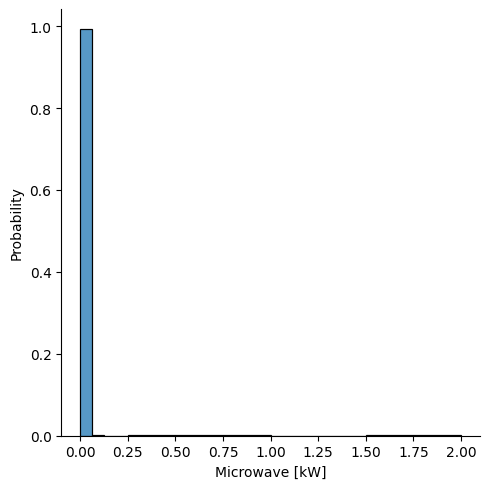

In [8]:

'''Producing a distribution plot in order to determine what an idle value for the microwave is during its operation 
(it is clearly visible that the value is below 0.0625)
'''

sns.displot(df_original['Microwave [kW]'], bins = [0, 0.0625, 0.125, 0.25, 0.50, 0.75, 1.00, 1.25, 1.50, 1.75, 2.00], stat = "probability")


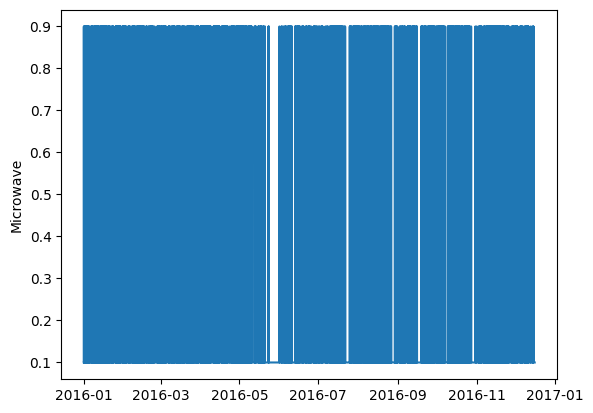

In [9]:
df = df_original[['Microwave [kW]']].copy(deep = True)
df.rename(columns={'Microwave [kW]':'Microwave'}, inplace=True)
#fdp.tresholding(data_frame=df, attribute='Microwave', graphing_interval=['2016-01-02 12:30:00', '2016-01-02 13:30:00'], treshold=0.0625)
fdp.tresholding(data_frame=df, attribute='Microwave', graphing_interval=[df_original.index[0], df_original.index[-1]], treshold=0.0625)

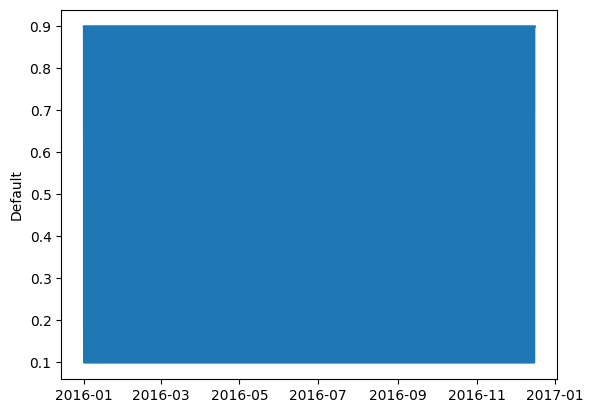

In [10]:


df['Default'] = ''
#fdp.set_default(hour_span=[(0,6),(18,23)],data_frame=df, attribute='Default', graphing_interval=['2016-01-04 00:00:00', '2016-01-05 00:00:00'])
fdp.set_default(hour_span=[(0,6),(18,23)],data_frame=df, attribute='Default', graphing_interval=[df_original.index[0], df_original.index[-1]])



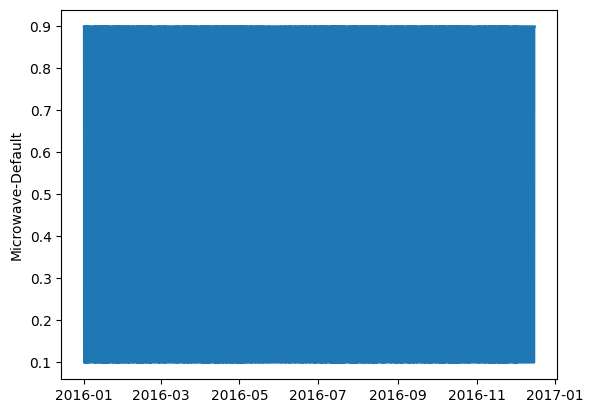

In [11]:
df['Microwave-Default'] = 0
#fdp.pre_process(data_frame=df, attribute_1='Microwave', attribute_2='Default', attribute_3='Microwave-Default',graphing_interval=['2016-01-02 12:30:00', '2016-01-02 13:30:00'])
fdp.pre_process(data_frame=df, attribute_1='Microwave', attribute_2='Default', attribute_3='Microwave-Default',graphing_interval=[df_original.index[0], df_original.index[-1]])

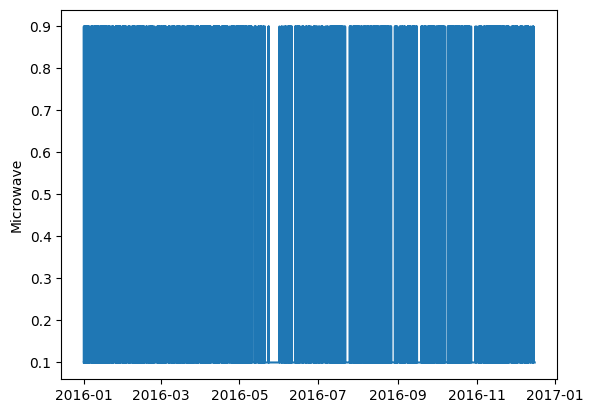

In [12]:
#fdp.post_process(data_frame=df, attribute = 'Microwave', time_span=['2016-01-02 12:30:00', '2016-01-02 13:30:00'],treshold_interval = 20)
fdp.post_process(data_frame=df, attribute = 'Microwave', time_span=[df_original.index[0], df_original.index[-19]],treshold_interval = 20)

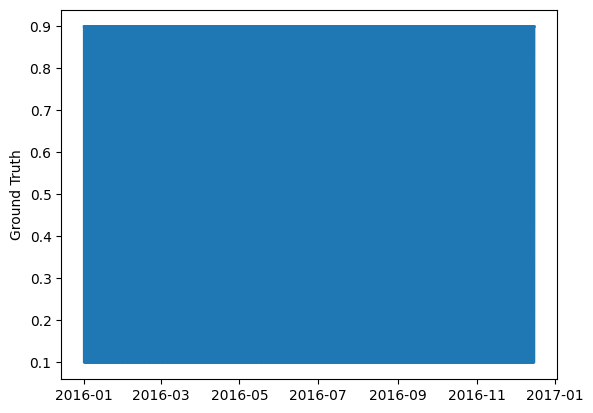

In [13]:




df['Ground Truth'] = ' '
#fdp.set_GT(hour_span=[(0,6),(18,23),(8,10)],data_frame=df, attribute='Ground Truth', graphing_interval=['2016-01-03 00:00:00', '2016-01-04 00:00:00'])
fdp.set_GT(hour_span=[(0,6),(18,23),(8,10)],data_frame=df, attribute='Ground Truth', graphing_interval=[df_original.index[0], df_original.index[-1]])




In [14]:
df['Ground Truth'].iloc[150:165]

2016-01-01 07:30:00    0.1
2016-01-01 07:31:00    0.1
2016-01-01 07:32:00    0.1
2016-01-01 07:33:00    0.1
2016-01-01 07:34:00    0.1
2016-01-01 07:35:00    0.1
2016-01-01 07:36:00    0.1
2016-01-01 07:37:00    0.1
2016-01-01 07:38:00    0.1
2016-01-01 07:39:00    0.1
2016-01-01 07:40:00    0.1
2016-01-01 07:41:00    0.1
2016-01-01 07:42:00    0.1
2016-01-01 07:43:00    0.1
2016-01-01 07:44:00    0.1
Freq: T, Name: Ground Truth, dtype: float64

In [15]:



df_temp = pd.DataFrame()
df_temp['Ground Truth'] = df['Ground Truth'].iloc[1:]
df = df.drop(df.tail(1).index)
df_temp.index = df_temp.index - pd.Timedelta(1 , 'min')
mask_00 = ((df['Ground Truth']==0.1) & (df_temp['Ground Truth']==0.1))
mask_11 = ((df['Ground Truth']==0.9) & (df_temp['Ground Truth']==0.9))
mask_01 = ((df_temp['Ground Truth']==0.1) & (df['Ground Truth']==0.9))
mask_10 = ((df['Ground Truth']==0.9) & (df_temp['Ground Truth']==0.1))

n_01 = (mask_01==True).sum()
n_00 = (mask_00==True).sum()
n_10 = (mask_10==True).sum()
n_11 = (mask_11==True).sum()

print(n_01, n_00, n_11, n_10)



700 167300 335210 700


In [16]:


n = n_01 + n_00 + n_11 + n_10

p_01 = n_01 / n
p_00 = n_00 / n
p_11 = n_11 / n
p_10 = n_10 / n

print(p_01, p_00, p_11, p_10)


0.0013891369490583636 0.3320037308249489 0.6652179952769344 0.0013891369490583636


In [17]:
mark = np.ones([2,2])
mark = [[p_00, p_01],[p_10, p_11]]

p = np.ones([2,n])

temp = np.ones([2,1])
df['Probability'] = " "

values = np.ones([2,n])

values[0,:] = df['Ground Truth']

values[1,:] = 1-values[0,:]


temp = mark @ values
p = temp

df['Probability'] = p[1,:]

    


In [18]:
df.iloc[115:125]

,Microwave,Default,Microwave-Default,Ground Truth,Probability
2016-01-01 06:55:00,0.1,0.9,0.9,0.9,0.067772
2016-01-01 06:56:00,0.1,0.9,0.9,0.9,0.067772
2016-01-01 06:57:00,0.1,0.9,0.9,0.9,0.067772
2016-01-01 06:58:00,0.1,0.9,0.9,0.9,0.067772
2016-01-01 06:59:00,0.1,0.9,0.9,0.9,0.067772
2016-01-01 07:00:00,0.1,0.1,0.1,0.1,0.598835
2016-01-01 07:01:00,0.1,0.1,0.1,0.1,0.598835
2016-01-01 07:02:00,0.1,0.1,0.1,0.1,0.598835
2016-01-01 07:03:00,0.1,0.1,0.1,0.1,0.598835
2016-01-01 07:04:00,0.1,0.1,0.1,0.1,0.598835


<AxesSubplot: >

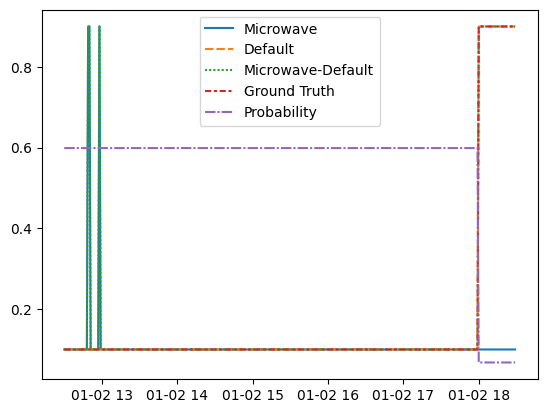

In [19]:


time_span = ['2016-01-02 12:30:00', '2016-01-02 18:30:00']

star_index_date = df.index.get_loc(time_span[0])
end_index_date = df.index.get_loc(time_span[1])

sns.lineplot( data = df[star_index_date:end_index_date])


In [20]:
df.to_csv('df.csv')